## Background

Pneumonia is a form of acute respiratory tract infection that affect the lungs. In 2017, pneumonia killed as many as 808 694 children under the age of 5, accounting for 15% of deaths among children under 5 years of age. Although pneumonia can affect people of all age groups, young children and the elderly, and people with pre-existent health problems are at the most risk. Pneumonia kills more children under five than AIDS, malaria and measles combined. Yet increased attention have been on the latter diseases.

There are more than 30 different causes of pneumonia, but the most common are bacteria and viruses. Bacterial pneumonia is caused by a variety of bacteria. The most common is Streptococcus pneumoniae, which usually occurs when the body is weakened in some way, such as by illenes, poor nutrition, old age or impaired imunity. Viral pneumonia is responsible for about one-third of all pneumonia cases, and are caused by various viruses, including the flu. You may be more likely to get bacterial pneumonia if you have viral pneumonia.

&nbsp;

## Objective

In this work, we are going to train a CNN (Convolutional Neural Network) in order to classify three classes of chest x-ray images, namely chest x-ray of healh lungs, and lungs affected by bacterial and viral types of pneumonia. We will be using Pytorch as our Deep Learning framework. The network architecture consists of a block of pretrained VGG16 convolutional layers, followed by a block of random initialized convolutional layers. The features learned by the convolutional layers are then passed through a stack of fully connected layers, which output raw unnormalized scores. The loss is computed using the CrossEntropyLoss() class provided by Pytorch, which combines nn.LogSoftmax() and nn.NLLLoss() in one single class. We also use dropout layers as regularizers and one batch normalization layer. We then evaluate the model using weighted Recall, Precion and F1-Score metrics.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Pytorch imports
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import (DataLoader,
                              Dataset,
                              TensorDataset)

from torch.optim import Adam, RMSprop, SGD
from torchvision import transforms
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision.transforms.functional as TF

# Albumentations imports
from albumentations.pytorch import ToTensor
import albumentations as A

# Sklearn metrics imports 
from sklearn.metrics import (f1_score, 
                             recall_score,
                             balanced_accuracy_score,
                             precision_score, 
                             roc_auc_score, 
                             classification_report, 
                             confusion_matrix)

from sklearn.model_selection import train_test_split

# For showing the confusion matrix
from mlxtend.plotting import plot_confusion_matrix

# Other imports
import cv2
import numpy as np
from copy import deepcopy
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from os.path import join
import joblib
import pandas as pd
import seaborn as sns
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading the data

In [0]:
def get_data_dict():
    data_dict = {}
    for path in PATHS:
        for filetype in FILETYPE:
            for filename in (filename for filename in os.listdir(join(path, filetype)) if '.jpeg' in filename):
                image = cv2.imread(join(path, filetype, filename))
                image = np.dstack([image]*3) if image.ndim==2 else image
                resized = cv2.resize(image, (224, 224))
                data_dict[filename] = resized
    return data_dict
data = get_data_dict()

In [0]:
data = joblib.load('/content/drive/My Drive/data/data_dict.joblib')

In [0]:
class_normal = np.array([data[key] for key, value in data.items() if ('bacteria' or 'virus') not in key])
class_bacteria = np.array([data[key] for key, value in data.items() if 'bacteria' in key])
class_virus = np.array([data[key] for key, value in data.items() if 'virus' in key])

# Downsample normal cases
class_normal = class_normal[:len(class_virus)+300]

targets = [0] * len(class_normal)
targets.extend([1] * len(class_bacteria))
targets.extend([2] * len(class_virus))

X_data, y_true = np.vstack([class_normal, class_bacteria, class_virus]), np.array(targets)

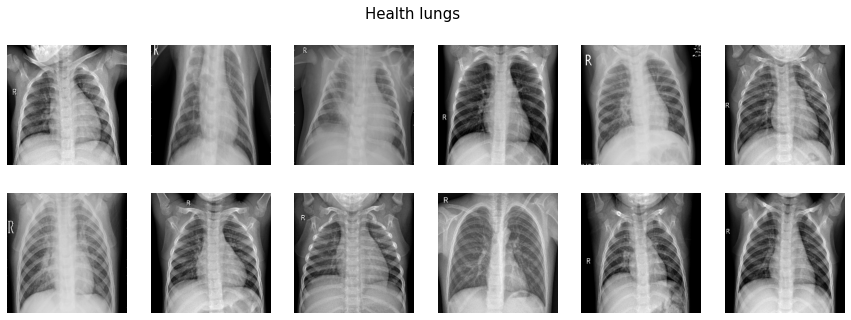

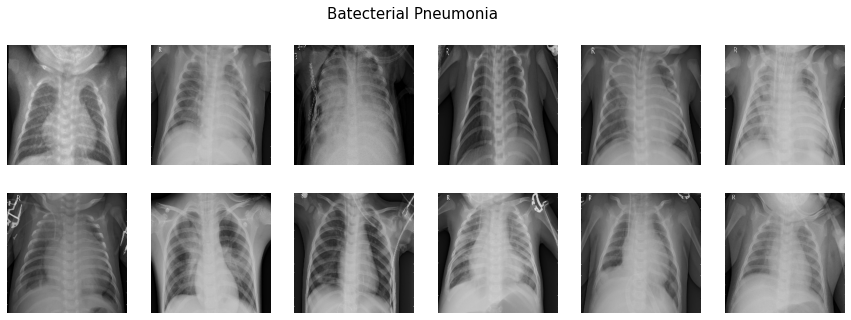

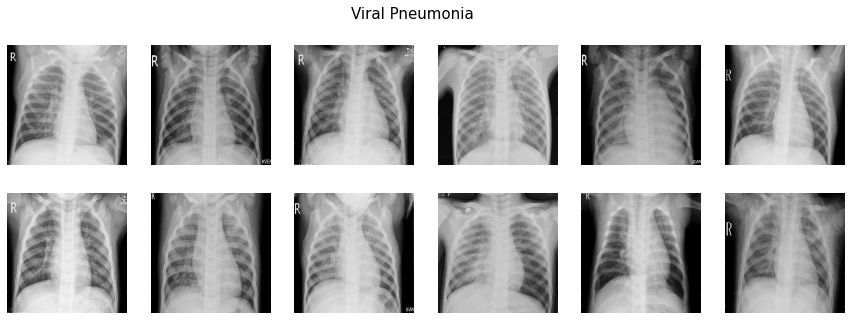

In [0]:
def visualize_samples(images, rows=1, cols=5, title=None):
    plt.figure(figsize=(2.5*cols, 2.5*rows)).suptitle(title, size=15, color='black')
    idx = np.random.choice(images.shape[0], size=rows*cols)
    for i, sample in enumerate(images[idx]):
        plt.subplot(rows, cols, i+1)
        plt.axis('off')
        plt.imshow(sample)
    plt.show()

visualize_samples(X_data[y_true==0], rows=2, cols=6, title='Health lungs')
visualize_samples(X_data[y_true==1], rows=2, cols=6, title='Batecterial Pneumonia')
visualize_samples(X_data[y_true==2], rows=2, cols=6, title='Viral Pneumonia')

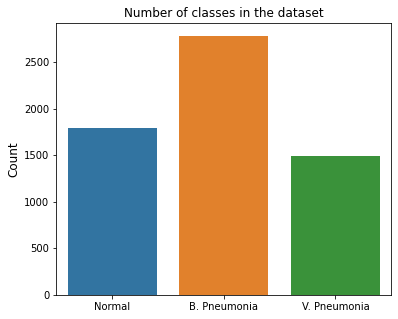

In [5]:
plt.figure(figsize=(6, 5))
sns.barplot(x=['Normal', 'B. Pneumonia', 'V. Pneumonia'], 
                y=list(Counter(sorted(y_true)).values()))
plt.title("Number of classes in the dataset")
plt.ylabel("Count", size=12)
plt.show()

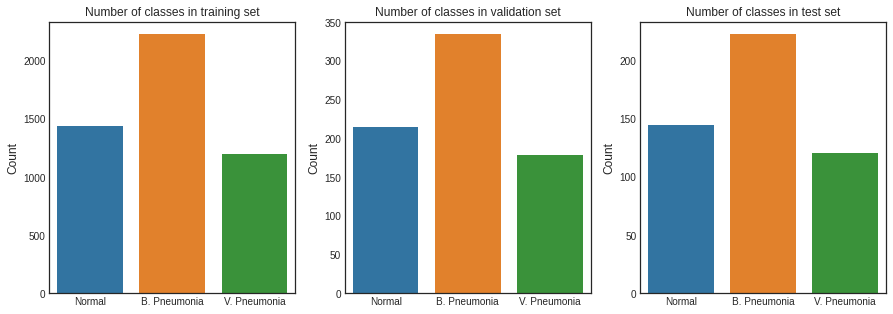

In [31]:
X_train, X_, y_train, y_ = train_test_split(X_data, y_true, test_size=.2, random_state=1, stratify=y_true)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=.4, random_state=1, stratify=y_)

plt.figure(figsize=(15, 5))
for i, (labels, set_name) in enumerate(zip([y_train, y_val, y_test], ['training', 'validation', 'test'])):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=['Normal', 'B. Pneumonia', 'V. Pneumonia'], 
                y=list(Counter(sorted(labels)).values()))
    plt.title("Number of classes in {} set".format(set_name), size=12)
    plt.ylabel("Count", size=12)
plt.show()

# Augmentation Pipeline

In [0]:
aug_pipeline = A.Compose([
                     A.OneOf([
                              A.ShiftScaleRotate(shift_limit=0, rotate_limit=0),
                              A.VerticalFlip(),
                              A.HorizontalFlip(),
                              A.RandomSizedCrop((100, 100), 224, 224, p=0.6),
                              A.RandomRotate90(),
                              A.GridDistortion()
                              ], p=.8),
                     ToTensor(),
                     ])

# DataLoaders and batchs preparation

In [0]:
# Declaring custom Pytorch Dataset subclasses

class TrainDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform 
  
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        target = torch.tensor(self.labels[index], dtype=torch.long)
        if self.transform is not None:
            image = self.transform(image=self.images[index])['image']
        else:
            image = TF.to_tensor(self.images[index])
        return image, target
        
        
class ValDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)
  
    def __getitem__(self, index):
        image = TF.to_tensor(self.images[index])
        target = torch.tensor(self.labels[index], dtype=torch.long)
        return image, target
    
    
class TestDataset(Dataset):
    def __init__(self, images):
        self.images = images
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = TF.to_tensor(self.images[index])
        return image.to(device)

In [0]:
traindata_params = dict(batch_size=32,
                        num_workers=6,
                        shuffle=True,
                        pin_memory=False)

valdata_params = dict(batch_size=64,
                      num_workers=6,
                      shuffle=True,
                      pin_memory=False)

testdata_params = dict(batch_size=1, 
                       shuffle=False, 
                       pin_memory=False)


# Creating DataLoaders for training, validation and test sets.
train_data = TrainDataset(images=X_train, labels=y_train, transform=aug_pipeline)
train_loader = DataLoader(train_data, **traindata_params)

val_data = ValDataset(images=X_val, labels=y_val)
val_loader = DataLoader(val_data, **valdata_params)

test_dataset = TestDataset(images=X_test)
test_loader = DataLoader(test_dataset, **testdata_params)

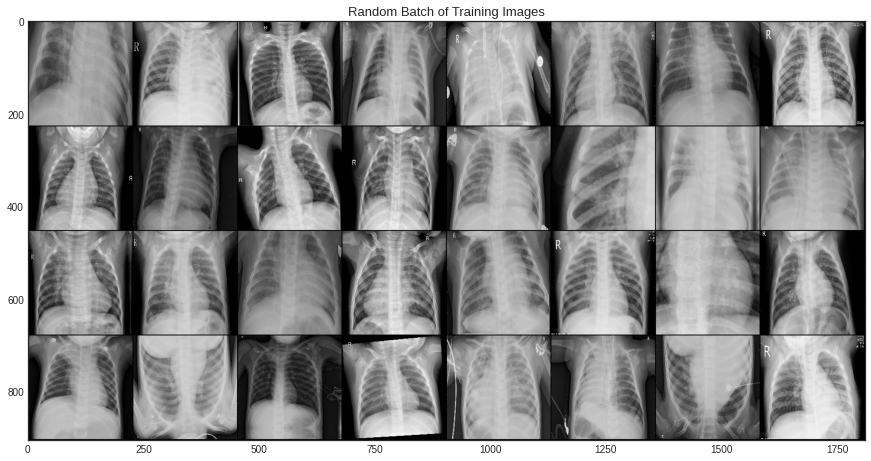

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(15, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Random Batch of Training Images", size=13)
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

# Model Architecture

In [0]:
model_conv = torchvision.models.vgg16(pretrained=True)
for params in model_conv.parameters():
    params.requires_grad = False
pretrained_layers = list(model_conv.features)[:5]

In [56]:
pretrained_layers

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
           *pretrained_layers,
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
    
       self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.6),
            nn.Linear(36864, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(256, 3),
            nn.Dropout(p=0.2)
       )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_layers(x)
        return x

In [59]:
model = Network().to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss().to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

9,883,011 total parameters.
9,844,291 training parameters.


 # Training

In [0]:
def visualize_eval(train_loss, val_loss) :
    plt.figure(figsize=(5, 5))
    epochs = range(1, 1 + len(train_loss)) 
    plt.style.use('seaborn-white')
    plt.plot(epochs, train_loss, color='blue', label='Train loss')
    plt.plot(epochs, val_loss, color='orange', label='Valdation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


def fit(model, train_loader=None, val_loader=None, epochs=15):
    torch.manual_seed(0)
    train_loss = []
    val_loss = []
    validation_loss_epoch = 0.0

    for epoch in range(1, epochs+1):
        print('\nEpoch {}/{}'.format(epoch, epochs))
        training_loss = []
        validation_loss = []
        val_loss_epoch = validation_loss_epoch

        model.train()
        for batch_x, batch_y in tqdm(train_loader):
            train_x, train_y = batch_x.to(device), batch_y.to(device)
            outputs = model(train_x) # forward propagation
            loss = criterion(outputs, train_y) # compute the loss
            training_loss.append(loss.item())
            loss.backward() # backpropagation 
            optimizer.step() # optimization step
            optimizer.zero_grad() # set parameter gradients to zero

        with torch.no_grad():
            model.eval()
            for val_batch_x, val_batch_y in val_loader:
                val_x, val_y = val_batch_x.to(device), val_batch_y.to(device)
                val_outputs = model(val_x)
                loss_val = criterion(val_outputs, val_y)
                validation_loss.append(loss_val.item())

        training_loss_epoch = np.mean(training_loss)
        validation_loss_epoch = np.mean(validation_loss)

        if validation_loss_epoch < val_loss_epoch:
            best_weights = deepcopy(model.state_dict())

        train_loss.append(training_loss_epoch)
        val_loss.append(validation_loss_epoch)
        print('\ttrain_loss: %.4f\t\n' % training_loss_epoch, '\tval_loss: %.4f\t' % validation_loss_epoch)
    visualize_eval(train_loss, val_loss)
    return best_weights


Epoch 1/30



	train_loss: 0.8990	
 	val_loss: 0.7017	

Epoch 2/30



	train_loss: 0.8269	
 	val_loss: 0.6861	

Epoch 3/30



	train_loss: 0.7906	
 	val_loss: 0.6513	

Epoch 4/30



	train_loss: 0.7652	
 	val_loss: 0.6515	

Epoch 5/30



	train_loss: 0.7589	
 	val_loss: 0.6336	

Epoch 6/30



	train_loss: 0.7426	
 	val_loss: 0.6267	

Epoch 7/30



	train_loss: 0.7240	
 	val_loss: 0.6206	

Epoch 8/30



	train_loss: 0.7192	
 	val_loss: 0.6320	

Epoch 9/30



	train_loss: 0.7095	
 	val_loss: 0.5958	

Epoch 10/30



	train_loss: 0.7100	
 	val_loss: 0.6151	

Epoch 11/30



	train_loss: 0.7026	
 	val_loss: 0.6035	

Epoch 12/30



	train_loss: 0.6895	
 	val_loss: 0.6319	

Epoch 13/30



	train_loss: 0.6765	
 	val_loss: 0.5913	

Epoch 14/30



	train_loss: 0.6795	
 	val_loss: 0.5976	

Epoch 15/30



	train_loss: 0.6825	
 	val_loss: 0.6123	

Epoch 16/30



	train_loss: 0.6652	
 	val_loss: 0.5896	

Epoch 17/30



	train_loss: 0.6597	
 	val_loss: 0.5923	

Epoch 18/30



	train_loss: 0.6600	
 	val_loss: 0.5695	

Epoch 19/30



	train_loss: 0.6572	
 	val_loss: 0.5855	

Epoch 20/30



	train_loss: 0.6532	
 	val_loss: 0.6194	

Epoch 21/30



	train_loss: 0.6519	
 	val_loss: 0.5837	

Epoch 22/30



	train_loss: 0.6359	
 	val_loss: 0.6041	

Epoch 23/30



	train_loss: 0.6388	
 	val_loss: 0.5747	

Epoch 24/30



	train_loss: 0.6364	
 	val_loss: 0.6080	

Epoch 25/30



	train_loss: 0.6390	
 	val_loss: 0.5793	

Epoch 26/30



	train_loss: 0.6336	
 	val_loss: 0.5821	

Epoch 27/30



	train_loss: 0.6320	
 	val_loss: 0.5839	

Epoch 28/30



	train_loss: 0.6269	
 	val_loss: 0.5644	

Epoch 29/30



	train_loss: 0.6350	
 	val_loss: 0.5891	

Epoch 30/30



	train_loss: 0.6143	
 	val_loss: 0.5621	


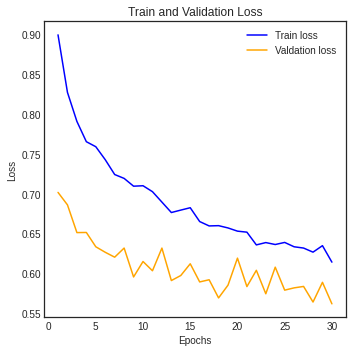

In [61]:
best_weights = fit(model, 
                   train_loader, 
                   val_loader,
                   epochs=30)

In [0]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [0]:
torch.save(model.state_dict(), '.../models/model_2.pt')

# Inference

In [0]:
model.eval()
test_outputs = torch.zeros((len(X_test), 3), dtype=torch.float, device=device)
with torch.no_grad():
    for i, test_batch_x in enumerate(test_loader):
        outputs = test_batch_x.to(device)
        test_outputs[i] = model(outputs)

_, predicted = torch.max(test_outputs, 1)
pred_classes = predicted.to('cpu').numpy()

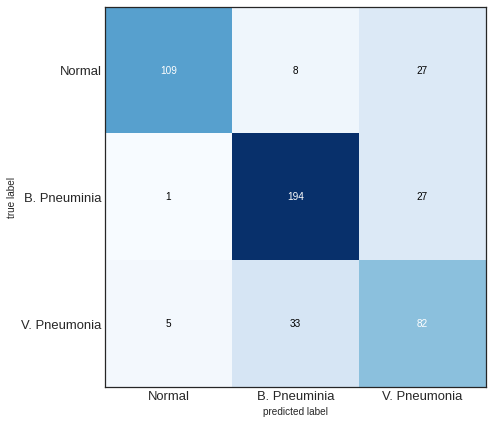

In [63]:
cm  = confusion_matrix(y_test, pred_classes)
plot_confusion_matrix(cm, figsize=(12, 7), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'B. Pneuminia', "V. Pneumonia"], fontsize=13)
plt.yticks(range(3), ['Normal', 'B. Pneuminia', "V. Pneumonia"], fontsize=13)
plt.show()

In [64]:
f1score = f1_score(y_test, pred_classes, average='weighted')
rec = recall_score(y_test, pred_classes, average='weighted')
pre = precision_score(y_test, pred_classes, average='weighted') 
scores = [f1score, rec, pre]

print("Weighted F1-Score --> %.1f%%" % (f1score * 100))
print("Weighted Recall --> %.1f%%" % (rec * 100))
print("Weighted Precision --> %.1f%%" % (pre * 100))

Weighted F1-Score --> 79.5%
Weighted Recall --> 79.2%
Weighted Precision --> 80.7%
